* [I. Import Data and Data Split](#I)
* [II. XGBoost Model with 3D Feature Set](#II)
    * [2.1 Number of neighboring atoms: 3](#2.1)
    * [2.2 Number of neighboring atoms: 5](#2.2)
    * [2.3 Number of neighboring atoms: 7](#2.3)
    * [2.4 Number of neighboring atoms: 10](#2.4)
    * [2.5 Compare Model Performance Using the Validation Dataset](#2.5)
    * [2.6 Feature Importance Analysis](#2.6)
* [III. XGBoost Model with 2D Feature Set](#III)
    * [3.1 Number of spheres: 2](#3.1)
    * [3.2 Number of spheres: 3](#3.2)
    * [3.3 Number of spheres: 4](#3.3)
    * [3.4 Number of spheres: 5](#3.4)
    * [3.5 Compare Model Performance Using the Validation Dataset ](#3.5)
    * [3.6 Feature Importance Analysis](#3.6)
* [IV. Evaluate Model Performance Using the Test Dataset](#IV)

In [1]:
# https://numpy.org/doc/stable/release.html
import numpy as np
import pandas as pd
import os
import sys

from sklearn.metrics import (
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import train_test_split

# plot
import matplotlib.pyplot as plt

%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.inspection import PartialDependenceDisplay

RANDOM_STATE = 1
src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_2D,
    atomic_features_3D,
)  # Some common methods I defined

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

import pickle

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. Import Data and Data Split <a class="anchor" id="I"></a>

In [2]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

all_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

# Train, validation, test dataset split
train_fluorinated_compounds, test_fluorinated_compounds = train_test_split(
    all_fluorinated_compounds, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
train_fluorinated_compounds, vali_fluorinated_compounds = train_test_split(
    train_fluorinated_compounds, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
print(
    f"Number of fluorinated_compounds in the train dataset: {train_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the validation dataset: {vali_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the test dataset: {test_fluorinated_compounds.shape[0]}"
)

Number of fluorinated_compounds in the train dataset: 439
Number of fluorinated_compounds in the validation dataset: 110
Number of fluorinated_compounds in the test dataset: 98


In [3]:
train_fluorinated_compounds.head(3)

,Group,IsPFAS(haveCF2),CAS,Compound name,Code,Solvent_used_for_NMR,Source,Note,SMILES,Internal Standard,FluorineInConjSystem,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
125,Perfluorinated ethers,True,863090-89-5,Perfluoro-4-methoxybutanoic acid,ether_12,D2O,EtherPFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)OC(F)(F)F,"hexafluorobenzene, ����",0.0,NaN,NaN,NaN,NaN,-119.90,-119.90,NaN,-129.40,-129.40,NaN,-87.70,-87.70,NaN,NaN,-57.80,-57.8,-57.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
429,NaN,False,NaN,"1,1,2-trifluorohex-1-ene",From_Review_266,CDCl3,NaN,NaN,CCCCC(F)=C(F)F,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-174.80,NaN,-106.70,-125.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Per- and polyfluorinated carboxylic acids,True,NaN,perfluorooctanoic acid,COOH_6,CDCl3,100+PFAS,NaN,O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,NaN,0.0,NaN,NaN,NaN,NaN,-119.16,-119.16,NaN,-121.84,-121.84,NaN,-122.19,-122.19,NaN,-122.88,-122.88,NaN,-123,-123.0,NaN,-126.27,-126.27,NaN,-80.95,-80.95,-80.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# II. XGBoost Model with 3D Feature Set <a class="anchor" id="II"></a>
**Use Atomic Features from Spatially Neighboring Atoms**

## 2.1 Number of neighbor atoms: 3 <a class="anchor" id="2.1"></a>
**Step 1. Combine atomic features with fluorinated compounds information**

In [4]:
# Combine NMR shift values of F atoms with its features
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=3, with_additional_info=True
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)
train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

# Save to file
file_path = os.path.join(
    "..", "dataset", "Output_Train_neiber3_w all CDK descriptors_440.csv"
)
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")

train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 82)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor2,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor2,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor2,PartialPiChargeDescriptor-pepe_neighbor2,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor2,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor2,PartialTChargePEOEDescriptor-pepeT_neighbor2,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor2,PiElectronegativityDescriptor-elecPiA_neighbor2,level_0_neighbor3,index_neighbor3,SMILES_neighbor3,AtomDegreeDescriptor-aNeg_neighbor3,AtomHybridizationDescriptor-aHyb_neighbor3,AtomHybridizationVSEPRDescriptor-hybr_neighbor3,AtomValenceDescriptor-val_neighbor3,BondsToAtomDescriptor-bondsToAtom_neighbor3,CovalentRadiusDescriptor-covalentRadius_neighbor3,DistanceToAtomDescriptor-distanceToAtom_neighbor3,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor3,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor3,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,SMILES,Compound name,Solvent_used_for_NMR
atomCode_fluorinated_compoundsCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4_ether_12,-119.9,F,1.0,3.0,3.0,7.0,3.0,0.72,2.843026,3.725625,0.0,1.268572,0.788288,0.0,-0.187374,-0.317,-0.187374,2.0,4.742414,0,3,C,4.0,3.0,3.0,4.0,2.0,0.77,2.451470,6.091250,0.0,0.777693,1.285855,0.0,0.404278,0.729,0.404278,2.0,0.0,1,5,F,1.0,3.0,3.0,7.0,3.0,0.72,3.521411,3.725625,0.0,1.273949,0.784961,0.0,-0.187374,-0.317,-0.187374,2.0,4.742414,2.0,6.0,C,4.0,3

In [5]:
dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}\n"
)

print("------Non numeric values in the dataset-------")
print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

print("\n")
print("-----Number of NaN values in each Column:-----")
print(dataset_dropNaN.isna().sum().sort_values(ascending=False))

Shape of the training dataset after dropping out columns with constant values: (2351, 67)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 67)

------Non numeric values in the dataset-------
Columns with Non-Numeric Values:
SMILES_neighbor2        2351
SMILES_neighbor3        2350
SMILES                  2351
Compound name           2351
Solvent_used_for_NMR    2351
dtype: int64
None


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 62)


-----Number of NaN values in each Column:-----
PiElectronegativityDescriptor-elecPiA_neighbor3               1
EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3    1
index_neighbor3                                               1
AtomDegreeDescriptor-aNeg_neighbor3                           1
AtomHybridizationDescriptor-aHyb_neighbor3                    1
                                                             ..
PiElectronegativityDescriptor-elecPiA_nei

In [6]:
columns = dataset_dropNaN.columns.tolist()

file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor3_xgboost.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

In [7]:
dataset = dataset_dropNaN

y_train = dataset["NMR_Peaks"]

# orig_features = ['SMILES', 'Compound name', 'Solvent_used_for_NMR', 'NMR_Peaks']
orig_features = ["NMR_Peaks"]
X_train = dataset.drop(orig_features, axis=1)

X_train = X_train.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

# Define a custom RMSE scoring function


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_scores = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f} ± {np.std(-best_scores["mean_test_mae"]):.2f}'
)
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(
    f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f} ± {np.std(-best_scores["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

# Save the model to a file
file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor3.json")
best_model.save_model(file_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 7.41 ± 4.62
Root Mean Squared Error (RMSE): 11.51
R^2 Score: 0.86 ± 0.14


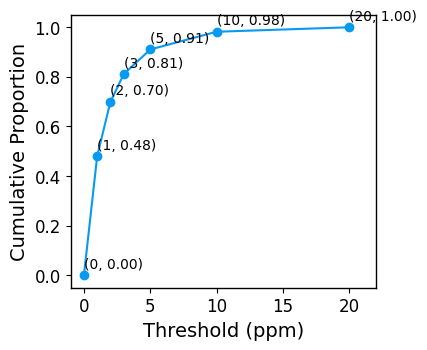

R2 = 0.99
RMSE = 3.11
MAE = 1.9075847842305544


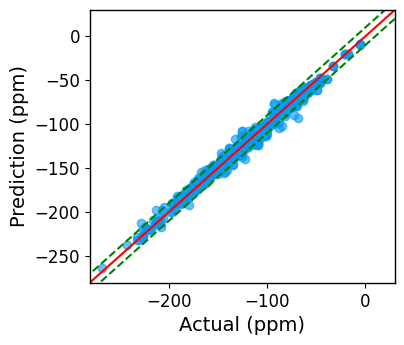

In [8]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table)

## 2.2 Number of neighbor atoms: 5 <a class="anchor" id="2.2"></a>
**Step 1. Combine atomic features with fluorinated compounds information**

In [9]:
# Combine NMR shift values of F atoms with its features
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=5, with_additional_info=True
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)
train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

# Save to file
file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "train_dataset_3D_neighbors5_w all CDK descriptors_440.csv",
)
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
# Transform all values to numeric values where possible
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 122)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,level_0_neighbor4,index_neighbor4,SMILES_neighbor4,AtomDegreeDescriptor-aNeg_neighbor4,AtomHybridizationDescriptor-aHyb_neighbor4,AtomHybridizationVSEPRDescriptor-hybr_neighbor4,AtomValenceDescriptor-val_neighbor4,BondsToAtomDescriptor-bondsToAtom_neighbor4,CovalentRadiusDescriptor-covalentRadius_neighbor4,DistanceToAtomDescriptor-distanceToAtom_neighbor4,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor4,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor4,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor4,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor4,PartialPiChargeDescriptor-pepe_neighbor4,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor4,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor4,PartialTChargePEOEDescriptor-pepeT_neighbor4,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor4,PiElectronegativityDescriptor-elecPiA_neighbor4,level_0_neighbor5,index_neighbor5,SMILES_neighbor5,AtomDegreeDescriptor-aNeg_neighbor5,AtomHybridizationDescriptor-aHyb_neighbor5,AtomHybridizationVSEPRDescriptor-hybr_neighbor5,AtomValenceDescriptor-val_neighbor5,BondsToAtomDescriptor-bondsToAtom_neighbor5,CovalentRadiusDescriptor-covalentRadius_neighbor5,DistanceToAtomDescriptor-distanceToAtom_neighbor5,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor5,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor5,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor5,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor5,PartialPiChargeDescriptor-pepe_neighbor5,Par

**Step 2. Data preprocessing**

In [10]:
dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}\n"
)

print("------Non numeric values in the dataset-------")
print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

print("\n")
print("-----Number of NaN values in each Column:-----")
print(dataset_dropNaN.isna().sum().sort_values(ascending=False))

Shape of the training dataset after dropping out columns with constant values: (2351, 105)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 105)

------Non numeric values in the dataset-------
Columns with Non-Numeric Values:
SMILES_neighbor2        2351
SMILES_neighbor3        2350
SMILES_neighbor4        2349
SMILES_neighbor5        2325
SMILES                  2351
Compound name           2351
Solvent_used_for_NMR    2351
dtype: int64
None


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 98)


-----Number of NaN values in each Column:-----
PiElectronegativityDescriptor-elecPiA_neighbor5               26
EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor5    26
index_neighbor5                                               26
AtomDegreeDescriptor-aNeg_neighbor5                           26
AtomHybridizationDescriptor-aHyb_neighbor5                    26
                                        

In [11]:
# dataset_dropNaN_encoded, encoder_neighbor5 = one_hot_encoding_of_smiles_neighborN(dataset_dropNaN, smiles_neighbors = ['SMILES_neighbor5', 'SMILES_neighbor4', 'SMILES_neighbor3', 'SMILES_neighbor2'])

# # Drop the categorical values in ['SMILES_neighbor5', 'SMILES_neighbor4', 'SMILES_neighbor3', 'SMILES_neighbor2', 'SMILES_neighbor1']
# dataset_dropNaN_dropCat = drop_smiles_neighborN(dataset_dropNaN, smiles_neighbors = ['SMILES_neighbor5', 'SMILES_neighbor4', 'SMILES_neighbor3', 'SMILES_neighbor2'])

In [12]:
# Save the encoder for future use in the valdiation/test dataset
# with open('encoder_neighbor5_xgboost.pkl', 'wb') as file:
#     pickle.dump(encoder_neighbor5, file)

columns = dataset_dropNaN.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

**Note:** When training with XGBoost, scaling of input features and filling NaN values are **not required**. Like other tree-based algorithms, XGBoost is not sensitive to the scale of the input features. Additionally, XGBoost does not require the removal of less relevant features, as it inherently performs feature selection during training by assigning lower importance to them.

**Step 3. Model Fitting**

In [13]:
dataset = dataset_dropNaN

y_train = dataset["NMR_Peaks"]

# orig_features = ['SMILES', 'Compound name', 'Solvent_used_for_NMR', 'NMR_Peaks']
orig_features = ["NMR_Peaks"]
X_train = dataset.drop(orig_features, axis=1)

X_train = X_train.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_scores = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f} ± {np.std(-best_scores["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-best_scores["mean_test_rmse"]):.2f} ± {np.std(-best_scores["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f} ± {np.std(-best_scores["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

# Save the model to a file
file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor5.json")
best_model.save_model(file_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 7.39 ± 4.63
Root Mean Squared Error (RMSE): 11.44 ± 5.24
R^2 Score: 0.86 ± 0.14


GridSearchCV is evaluating 12 different combinations of hyperparameters, and for each of these combinations, it is performing 3-fold cross-validation. This results in a total of 36 training fits across your data. Each fit corresponds to training the model with one specific set of hyperparameters on a training set and validating it on a validation set.

In [14]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

> Feature Importance: to understand which features are most influentail in making predictions. XGBoost provides several ways to evaluate feature importance. The improvement in accuracy brought by a feature to the branches it is on. Gain is often considered the most relevant attribute to interpret feature importance.

**Step 4. Visualize model performance in the train dataset**

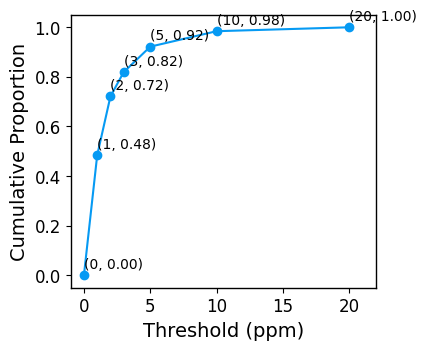

In [15]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)

R2 = 0.99
RMSE = 2.88
MAE = 1.784764434275947


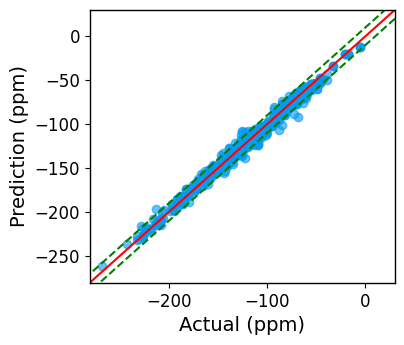

In [16]:
common.show_results_scatter(results_table, figure_title=None)

Prediction Performance of the training dataset using XGBoost Model with atomic features from 5 nearest neighbor atoms in 3D space.

### 2.3 Number of neighbor atoms: 7 <a class="anchor" id="2.3"></a>
**Step 1. Combine atomic features with fluorinated compounds information**

In [17]:
# Combine NMR shift values of F atoms with its features
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=7
)

train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)

# Transform all values to numeric values where possible
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "train_dataset_3D_neighbors7_w all CDK descriptors_440.csv",
)
train_fluorinated_compounds_w_Desc.to_csv(
    file_path,
    encoding="UTF-8",
)
print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 162)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor5,PartialPiChargeDescriptor-pepe_neighbor5,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor5,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor5,PartialTChargePEOEDescriptor-pepeT_neighbor5,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor5,PiElectronegativityDescriptor-elecPiA_neighbor5,level_0_neighbor6,index_neighbor6,SMILES_neighbor6,AtomDegreeDescriptor-aNeg_neighbor6,AtomHybridizationDescriptor-aHyb_neighbor6,AtomHybridizationVSEPRDescriptor-hybr_neighbor6,AtomValenceDescriptor-val_neighbor6,BondsToAtomDescriptor-bondsToAtom_neighbor6,CovalentRadiusDescriptor-covalentRadius_neighbor6,DistanceToAtomDescriptor-distanceToAtom_neighbor6,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor6,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor6,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor6,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor6,PartialPiChargeDescriptor-pepe_neighbor6,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor6,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor6,PartialTChargePEOEDescriptor-pepeT_neighbor6,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor6,PiElectronegativityDescriptor-elecPiA_neighbor6,level_0_neighbor7,index_neighbor7,SMILES_neighbor7,AtomDegreeDescriptor-aNeg_neighbor7,AtomHybridizationDescriptor-aHyb_neighbor7,AtomHybridizationVSEPRDescriptor-hybr_neighbor7,AtomValenceDescriptor-val_neighbor7,BondsToAtomDescriptor-bondsToAtom_neighbor7,CovalentRadiusDescriptor-covalentRadius_neighbor7,DistanceToAtomDescriptor-distanceToAtom_neighbor7,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor7,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor7,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor7,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor7,PartialPiChargeDescriptor-pepe_neighbor7,Par

**Step 2. Data preprocessing**

In [18]:
train_dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(train_dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}\n"
)

print("------Non numeric values in the dataset-------")
print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

print("\n")
print("-----Number of NaN values in each Column:-----")
print(dataset_dropNaN.isna().sum().sort_values(ascending=False))

Shape of the training dataset after dropping out columns with constant values: (2351, 141)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 141)

------Non numeric values in the dataset-------
Columns with Non-Numeric Values:
SMILES_neighbor2        2351
SMILES_neighbor3        2350
SMILES_neighbor4        2349
SMILES_neighbor5        2325
SMILES_neighbor6        2268
SMILES_neighbor7        2217
SMILES                  2351
Compound name           2351
Solvent_used_for_NMR    2351
dtype: int64
None


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 132)


-----Number of NaN values in each Column:-----
PiElectronegativityDescriptor-elecPiA_neighbor7               132
EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor7    132
index_neighbor7                                               132
AtomDegreeDescriptor-aNeg_neighbor7                           132
AtomHybridizationDescriptor-aHyb_neighbor7

In [19]:
# Save the encoder for future use in the valdiation/test dataset
# with open('encoder_neighbor7_xgboost.pkl', 'wb') as file:
#     pickle.dump(encoder_neighbor7, file)

columns = dataset_dropNaN.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor7_xgboost.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

**Step 3. Model Fitting**

In [20]:
dataset = dataset_dropNaN

y_train = dataset["NMR_Peaks"]

# orig_features = ['SMILES', 'Compound name', 'Solvent_used_for_NMR', 'NMR_Peaks']
orig_features = ["NMR_Peaks"]
X_train = dataset.drop(orig_features, axis=1)

X_train = X_train.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_scores = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f} ± {np.std(-best_scores["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-best_scores["mean_test_rmse"]):.2f} ± {np.std(-best_scores["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f} ± {np.std(-best_scores["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

# Save the model to a file
file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor7.json")
best_model.save_model(file_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 7.42 ± 4.61
Root Mean Squared Error (RMSE): 11.50 ± 5.19
R^2 Score: 0.86 ± 0.14


**Step 4. Visualize model performance in the train dataset**

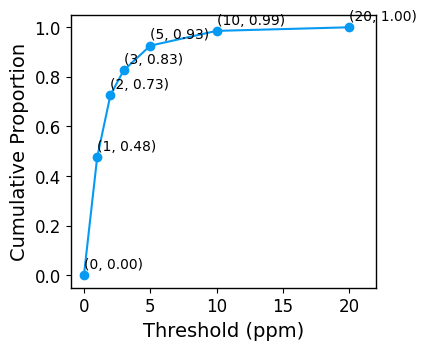

In [21]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)

R2 = 0.99
RMSE = 2.85
MAE = 1.7731184005001457


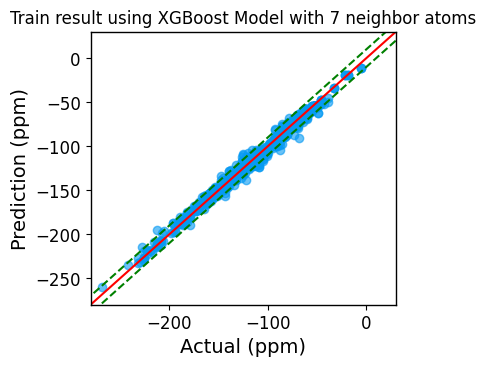

In [22]:
common.show_results_scatter(
    results_table, figure_title="Train result using XGBoost Model with 7 neighbor atoms"
)

Prediction Performance of the training dataset using XGBoost Model with atomic features from 7 nearest neighbor atoms in 3D space.

## 2.4 Number of neighbor atoms: 10 <a class="anchor" id="2.4"></a>
**Step 1. Combine atomic features with fluorinated compounds information**

In [23]:
# Combine NMR shift values of F atoms with its features
train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, neighbor_num=10
)
train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)

train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)

print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "train_dataset_3D_neighbors10_w all CDK descriptors_440.csv",
)
train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")

train_fluorinated_compounds_w_Desc.head(3)

Shape of the train_fluorinated_compounds_w_Desc: (2351, 222)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor8,PartialPiChargeDescriptor-pepe_neighbor8,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor8,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor8,PartialTChargePEOEDescriptor-pepeT_neighbor8,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor8,PiElectronegativityDescriptor-elecPiA_neighbor8,level_0_neighbor9,index_neighbor9,SMILES_neighbor9,AtomDegreeDescriptor-aNeg_neighbor9,AtomHybridizationDescriptor-aHyb_neighbor9,AtomHybridizationVSEPRDescriptor-hybr_neighbor9,AtomValenceDescriptor-val_neighbor9,BondsToAtomDescriptor-bondsToAtom_neighbor9,CovalentRadiusDescriptor-covalentRadius_neighbor9,DistanceToAtomDescriptor-distanceToAtom_neighbor9,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor9,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor9,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor9,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor9,PartialPiChargeDescriptor-pepe_neighbor9,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor9,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor9,PartialTChargePEOEDescriptor-pepeT_neighbor9,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor9,PiElectronegativityDescriptor-elecPiA_neighbor9,level_0_neighbor10,index_neighbor10,SMILES_neighbor10,AtomDegreeDescriptor-aNeg_neighbor10,AtomHybridizationDescriptor-aHyb_neighbor10,AtomHybridizationVSEPRDescriptor-hybr_neighbor10,AtomValenceDescriptor-val_neighbor10,BondsToAtomDescriptor-bondsToAtom_neighbor10,CovalentRadiusDescriptor-covalentRadius_neighbor10,DistanceToAtomDescriptor-distanceToAtom_neighbor10,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor10,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor10,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor10,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor10,PartialPiChargeDescriptor-pepe

**Step 2. Data preprocessing**

In [24]:
dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}\n"
)

print("------Non numeric values in the dataset-------")
print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

print("\n")
print("-----Number of NaN values in each Column:-----")
print(dataset_dropNaN.isna().sum().sort_values(ascending=False))

Shape of the training dataset after dropping out columns with constant values: (2351, 195)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2351, 195)

------Non numeric values in the dataset-------
Columns with Non-Numeric Values:
SMILES_neighbor2        2351
SMILES_neighbor3        2350
SMILES_neighbor4        2349
SMILES_neighbor5        2325
SMILES_neighbor6        2268
                        ... 
SMILES_neighbor9        2080
SMILES_neighbor10       1980
SMILES                  2351
Compound name           2351
Solvent_used_for_NMR    2351
Length: 12, dtype: int64
None


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2281, 183)


-----Number of NaN values in each Column:-----
PiElectronegativityDescriptor-elecPiA_neighbor10               361
EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor10    361
index_neighbor10                                               361
AtomDegreeDescriptor-aNeg_neighbor1

In [25]:
# # One Hot Encoding of Categorical Columns
# smiles_neighbors = ['SMILES_neighbor10', 'SMILES_neighbor9', 'SMILES_neighbor8', 'SMILES_neighbor7', 'SMILES_neighbor6', 'SMILES_neighbor5', 'SMILES_neighbor4', 'SMILES_neighbor3', 'SMILES_neighbor2']
# dataset_dropNaN_encoded, encoder_neighbor10 = one_hot_encoding_of_smiles_neighborN(dataset_dropNaN, smiles_neighbors)

# dataset_dropNaN_dropCat = drop_smiles_neighborN(dataset_dropNaN_encoded, smiles_neighbors)

In [26]:
# Save the encoder for future use in the valdiation/test dataset
# with open('encoder_neighbor10_xgboost.pkl', 'wb') as file:
#     pickle.dump(encoder_neighbor10, file)

columns = dataset_dropNaN.columns.tolist()
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor10_xgboost.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

**Step 3. Model Fitting**

In [27]:
dataset = dataset_dropNaN

y_train = dataset["NMR_Peaks"]

# orig_features = ['SMILES', 'Compound name', 'Solvent_used_for_NMR', 'NMR_Peaks']
orig_features = ["NMR_Peaks"]
X_train = dataset.drop(orig_features, axis=1)

X_train = X_train.apply(pd.to_numeric)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
best_scores = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f} ± {np.std(-best_scores["mean_test_mae"]):.2f}'
)
print(
    print(
        f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}"
    )
)
print(
    f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f} ± {np.std(-best_scores["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor10.json")
best_model.save_model(file_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 7.42 ± 4.60
Root Mean Squared Error (RMSE): 11.49
None
R^2 Score: 0.86 ± 0.14


**Step 4. Visualize model performance in the train dataset**

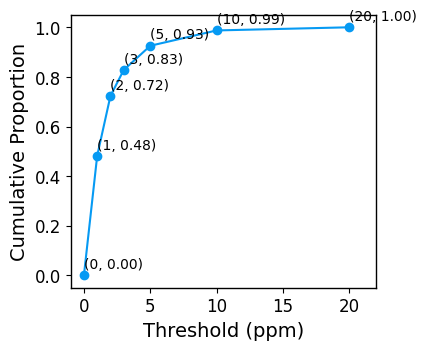

In [28]:
results_table = common.get_results_table(best_model, X_train, y_train)
common.plot_prediction_performance(results_table)

R2 = 0.99
RMSE = 2.79
MAE = 1.7373771050974551


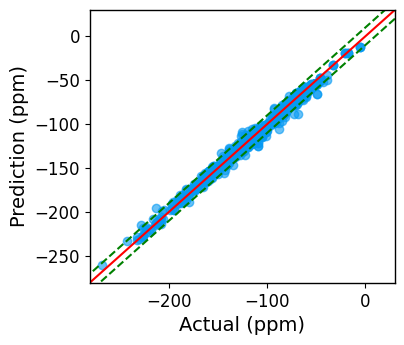

In [29]:
common.show_results_scatter(results_table, figure_title=None)

Prediction Performance of the training dataset using XGBoost Model with atomic features from 10 nearest neighbor atoms in 3D space.

## 2.5 Compare Model Performance Using the Validation Dataset <a class="anchor" id="2.5"></a>

We defined a function in the utils.py file to evaluate the performance of an XGBoost model using a validation or test dataset.

The function 'testModelPerformance_XGBoost_3DNeighborAtoms' mainly consists of four main steps:

    a. Import necessary models, encoders, and column names used for model training.
    b. Process the validation dataset to ensure it matches the structure of the training dataset.
    c. Visualize the model fitting results.

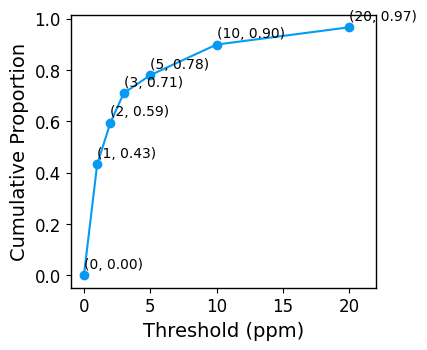

R2 = 0.94
RMSE = 7.36
MAE = 3.7487158163461483


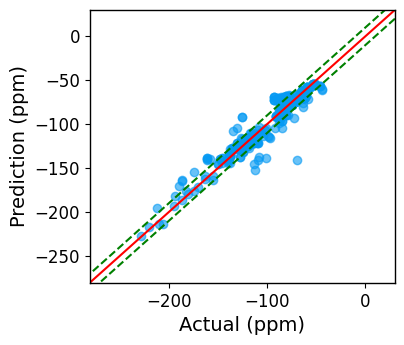

In [30]:
# Test model performance on the validation dataset, 3D atomic features with 3 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")

results_table_vali_neighbor_3 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor3.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor3_xgboost.pkl"
        ),
        neighbor_num=3,
        test_dataset=vali_fluorinated_compounds,
    )
)

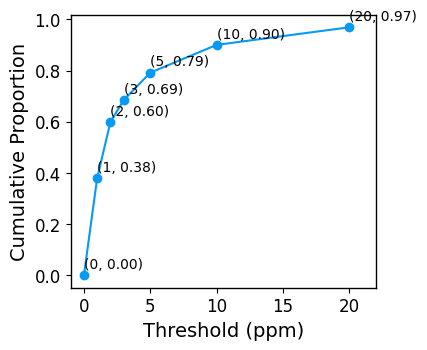

R2 = 0.94
RMSE = 6.96
MAE = 3.6410963360614375


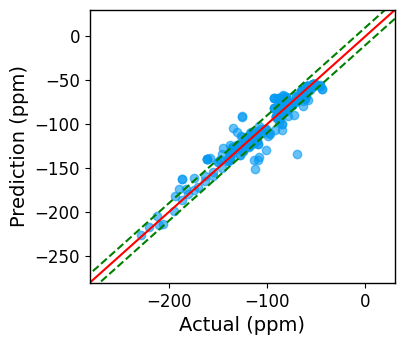

In [31]:
# Test model performance on the validation dataset, 3D atomic features with 5 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")
results_table_vali_neighbor_5 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor5.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor5_xgboost.pkl"
        ),
        neighbor_num=5,
        test_dataset=vali_fluorinated_compounds,
    )
)

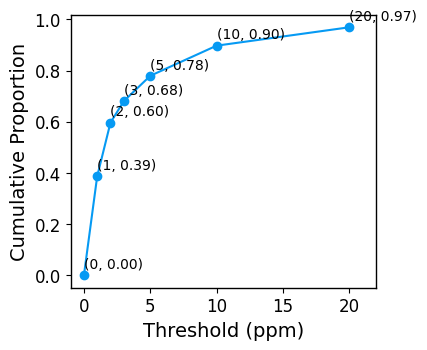

R2 = 0.94
RMSE = 7.20
MAE = 3.7565478895928157


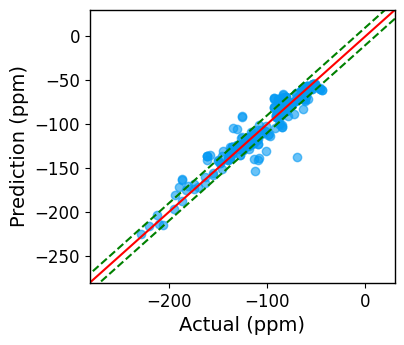

In [32]:
# Test model performance on the validation dataset, 3D atomic features with 7 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")
results_table_vali_neighbor_7 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor7.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor7_xgboost.pkl"
        ),
        neighbor_num=7,
        test_dataset=vali_fluorinated_compounds,
    )
)

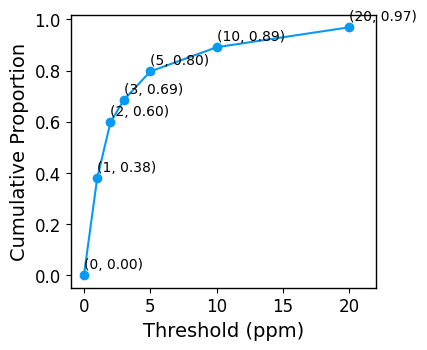

R2 = 0.94
RMSE = 7.28
MAE = 3.756297160390684


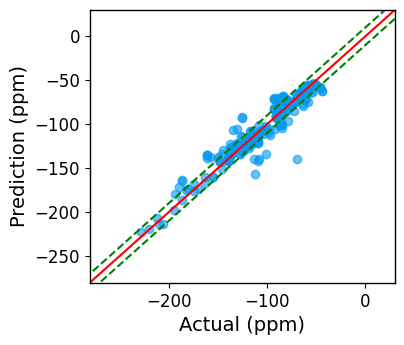

In [33]:
# Test model performance on the validation dataset, 3D atomic features with 10 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")
results_table_vali_neighbor_10 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor10.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor10_xgboost.pkl"
        ),
        neighbor_num=10,
        test_dataset=vali_fluorinated_compounds,
    )
)

**The optimal number of neighbor atoms are 5.**

In [34]:
# Save the optimal results to a CSV file
file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "XGBoost_descriptors from 5 spatially neighboring atoms_validation dataset fitting results.csv",
)
results_table_vali_neighbor_5.to_csv(file_path, encoding="UTF-8")

## 2.6 Feature Importance Analysis Use the Train Dataset <a class="anchor" id="2.6"></a>
**Top 10 Important Features Evaluated Based on Information Gain**

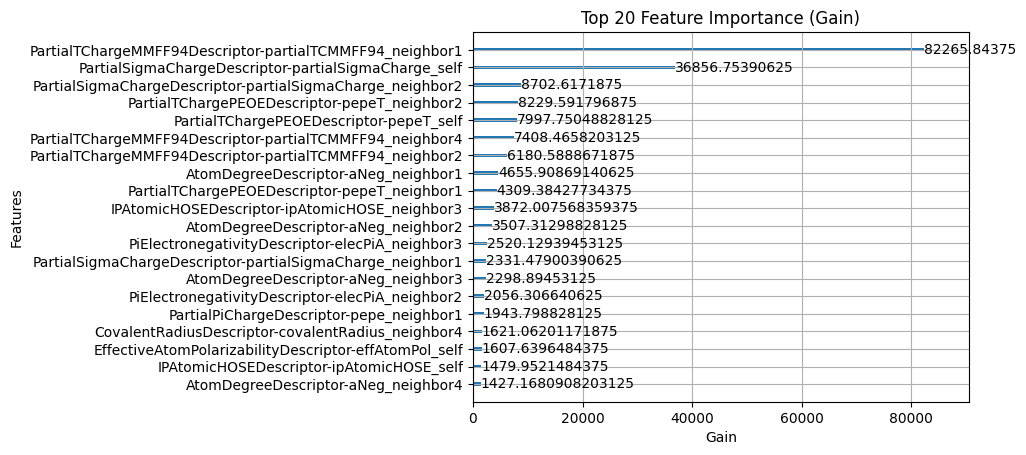

In [35]:
best_model = XGBRegressor()
file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor5.json")
best_model.load_model(file_path)

xgb.plot_importance(best_model, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importance (Gain)")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()

Features used for modeling:
* 1. BondsToAtomDescriptor-bondsToAtom_self
* 2. DistanceToAtomDescriptor-distanceToAtom_self
* 3. EffectiveAtomPolarizabilityDescriptor-effAtomPol_self
* 4. IPAtomicHOSEDescriptor-ipAtomicHOSE_self
* 5. InductiveAtomicHardnessDescriptor-indAtomHardnesss_self
* 6. InductiveAtomicSoftnessDescriptor-indAtomSoftness_self
* 7. PartialPiChargeDescriptor-pepe_self
* 8. PartialSigmaChargeDescriptor-partialSigmaCharge_self
* 9. PartialTChargeMMFF94Descriptor-partialTCMMFF94_self
* 10. PiElectronegativityDescriptor-elecPiA_self
* 11. ProtonAffinityHOSEDescriptor-protonAffiHOSE_self
* 12. RDFProtonDescriptor_G3R-g3r_2_self
----------
* index_neighbor1
* AtomDegreeDescriptor-aNeg_neighbor1
* AtomHybridizationDescriptor-aHyb_neighbor1
* 1. BondsToAtomDescriptor-bondsToAtom_neighbor1
* 2. DistanceToAtomDescriptor-distanceToAtom_neighbor1
* 3. EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1
* 5. InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1
* 6. InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1
* 7. PartialPiChargeDescriptor-pepe_neighbor1
* 8. PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1
* 9. PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1
* PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1
* 10. PiElectronegativityDescriptor-elecPiA_neighbor1
* 12. RDFProtonDescriptor_G3R-g3r_2_neighbor1

**SHAP**

In [36]:
file_path = os.path.join(
    "..",
    "artifacts",
    "temp",
    "train_dataset_3D_neighbors5_w all CDK descriptors_440.csv",
)

train_fluorinated_compounds_w_Desc = pd.read_csv(
    file_path,
    encoding="UTF-8",
    index_col=0,
)
# encoder_path = 'encoder_neighbor5_xgboost.pkl'


# with open(encoder_path, 'rb') as file:
#         encoder = pickle.load(file)

file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
)
with open(file_path, "rb") as f:
    train_cols = pickle.load(f)
# neighbor_atoms_list = ['SMILES_neighbor7', 'SMILES_neighbor6','SMILES_neighbor5', 'SMILES_neighbor4',
#                        'SMILES_neighbor3', 'SMILES_neighbor2']

# encoded = encoder.transform(train_fluorinated_compounds_w_Desc[neighbor_atoms_list])
# df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(neighbor_atoms_list))
# df_encoded.index = train_fluorinated_compounds_w_Desc.index
# train_fluorinated_compounds_w_Desc = pd.concat([train_fluorinated_compounds_w_Desc, df_encoded], axis=1)

train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc[train_cols]
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.dropna(
    subset=["NMR_Peaks"]
)

# columns_to_drop = ['SMILES', 'Compound name', 'Solvent_used_for_NMR', 'NMR_Peaks']
columns_to_drop = ["NMR_Peaks"]
X_train = train_fluorinated_compounds_w_Desc.drop(columns_to_drop, axis=1)

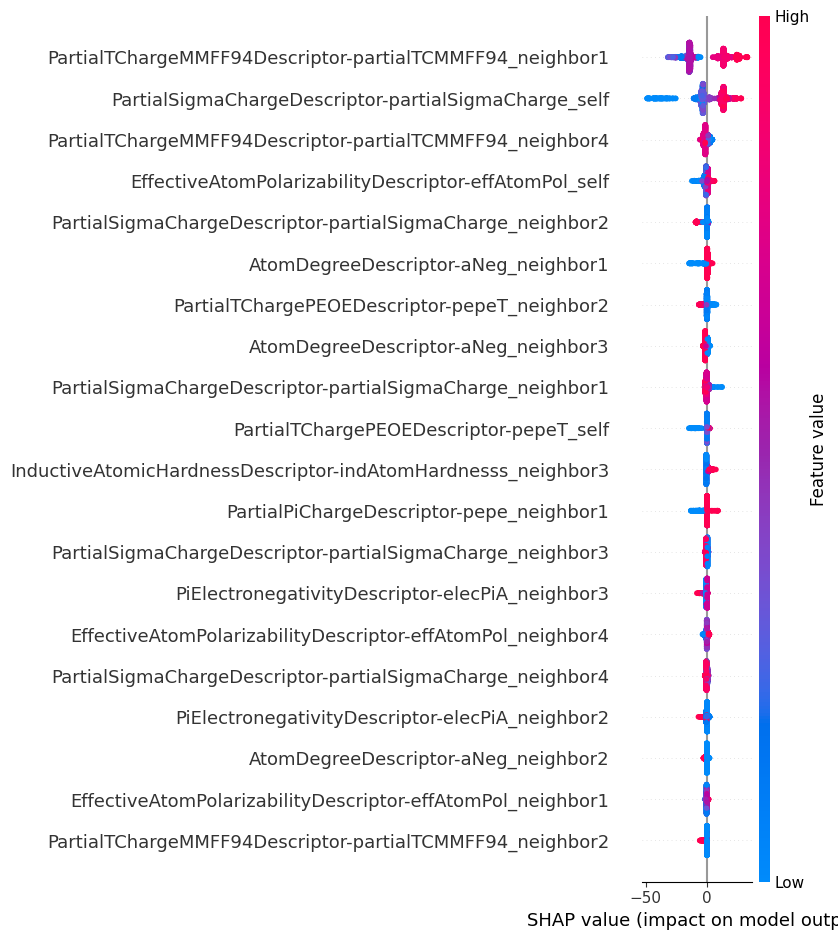

In [37]:
# Create the SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# Plot the summary plot
shap.summary_plot(shap_values, X_train)

This summary plot shows the distribution of SHAP values for each feature, indicating how each feature contributes positively or negatively to the predictions.

**Partial Dependence Plots (PDP)**

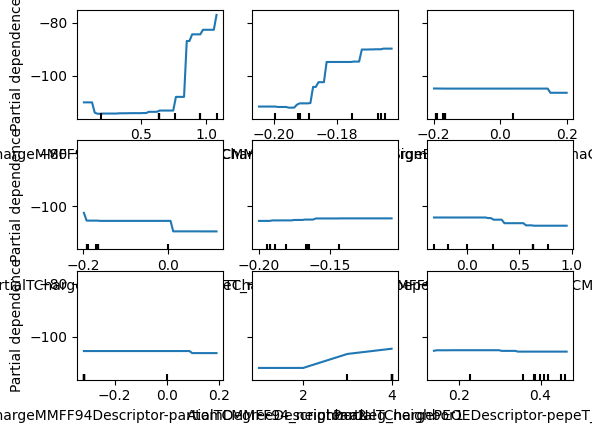

In [38]:
importance = best_model.get_booster().get_score(importance_type="gain")
importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Gain"])

# Sort by gain and get the top N features
top_n = 9  # Change this to the number of features you want to plot
top_importance_df = importance_df.sort_values(by="Gain", ascending=False).head(top_n)

# Extract the feature names for the PDP
top_features = top_importance_df["Feature"].tolist()

# Plot Partial Dependence Plots for the top features
disp = PartialDependenceDisplay.from_estimator(
    best_model, X_train, features=top_features, grid_resolution=50
)

plt.show()

# III. XGBoost Model with 2D Feature Set<a class="anchor" id="III"></a>
## 3.1 Number of spheres: 2<a class="anchor" id="3.1"></a>

In [39]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 2
)
train_content

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,NMR_Peaks
4_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-119.9
5_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-119.9
7_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-129.4
8_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,-129.4
10_ether_12,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,15.999,3.0,0.0,2.0,2.0,2.0,0.0,-87.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
27_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
29_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02
30_acrylates_8,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,-72.02


In [40]:
train_content = train_content.dropna(subset=["NMR_Peaks"])
y_train = train_content["NMR_Peaks"]

X_train = train_content.drop(["NMR_Peaks"], axis=1)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-cv_results["mean_test_rmse"]):.2f} ± {np.std(-cv_results["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere2.json"
)
best_model.save_model(file_path)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 10, 'reg_alpha': 2, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 8.67 ± 4.83
Root Mean Squared Error (RMSE): 13.27 ± 5.56
R^2 Score: 0.81 ± 0.16


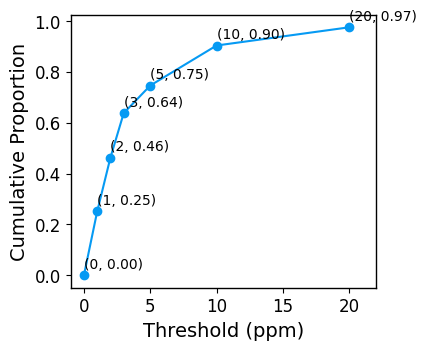

In [41]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)

R2 = 0.96
RMSE = 6.91
MAE = 4.141189860687525


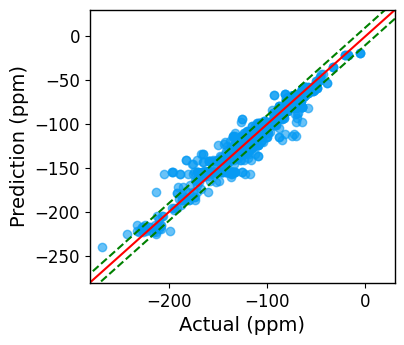

In [42]:
common.show_results_scatter(results_table, figure_title=None)

## 3.2 Number of spheres: 3<a class="anchor" id="3.2"></a>

In [43]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 3
)
print(f"Shape of the train dataset: {train_content.shape}")

train_content = train_content.dropna(subset=["NMR_Peaks"])
y_train = train_content["NMR_Peaks"]

X_train = train_content.drop(["NMR_Peaks"], axis=1)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-cv_results["mean_test_rmse"]):.2f} ± {np.std(-cv_results["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere3.json"
)
best_model.save_model(file_path)

Shape of the train dataset: (2351, 92)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 8.01 ± 5.07
Root Mean Squared Error (RMSE): 12.53 ± 5.71
R^2 Score: 0.83 ± 0.16


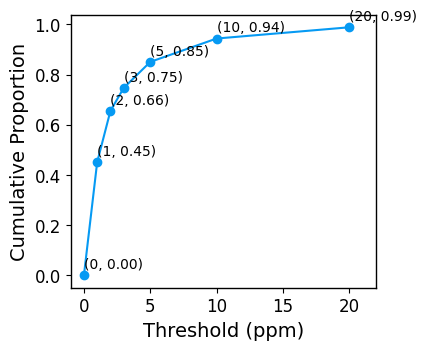

R2 = 0.98
RMSE = 4.91
MAE = 2.73121340764386


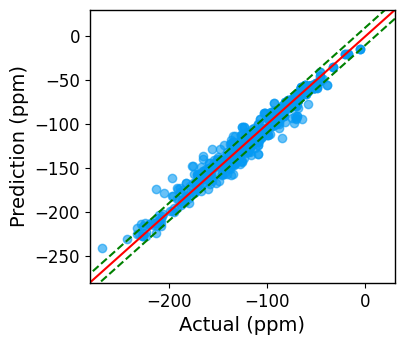

In [44]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table, figure_title=None)

## 3.3 Number of spheres: 4<a class="anchor" id="3.3"></a>

In [45]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 4
)
print(f"Shape of the train dataset: {train_content.shape}")

train_content = train_content.dropna(subset=["NMR_Peaks"])
y_train = train_content["NMR_Peaks"]

X_train = train_content.drop(["NMR_Peaks"], axis=1)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-cv_results["mean_test_rmse"]):.2f} ± {np.std(-cv_results["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
)
best_model.save_model(file_path)

Shape of the train dataset: (2351, 162)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 8.02 ± 5.06
Root Mean Squared Error (RMSE): 12.58 ± 5.68
R^2 Score: 0.83 ± 0.16


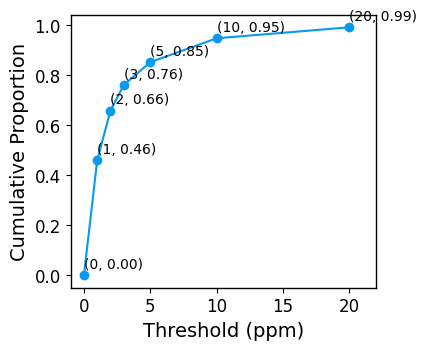

R2 = 0.98
RMSE = 4.72
MAE = 2.6477239397850107


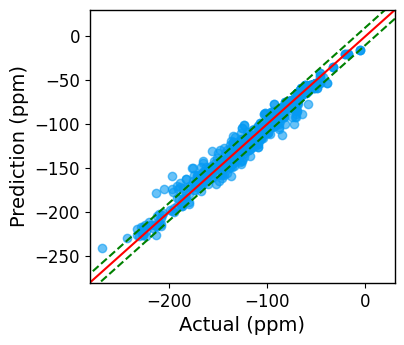

In [46]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table, figure_title=None)

## 3.4 Number of spheres: 5<a class="anchor" id="3.4"></a>

In [47]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 5
)
print(f"Shape of the train dataset: {train_content.shape}")

train_content = train_content.dropna(subset=["NMR_Peaks"])
y_train = train_content["NMR_Peaks"]

X_train = train_content.drop(["NMR_Peaks"], axis=1)

# Set Hyperparameters
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(
        mean_squared_error, squared=False, greater_is_better=False
    ),  # Root Mean Squared Error
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    cv=3,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
cv_results = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-cv_results["mean_test_mae"]):.2f} ± {np.std(-cv_results["mean_test_mae"]):.2f}'
)
print(
    f'Root Mean Squared Error (RMSE): {np.mean(-cv_results["mean_test_rmse"]):.2f} ± {np.std(-cv_results["mean_test_rmse"]):.2f}'
)
print(
    f'R^2 Score: {np.mean(cv_results["mean_test_r2"]):.2f} ± {np.std(-cv_results["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere5.json"
)
best_model.save_model(file_path)

Shape of the train dataset: (2351, 232)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 8.03 ± 5.05
Root Mean Squared Error (RMSE): 12.60 ± 5.67
R^2 Score: 0.83 ± 0.16


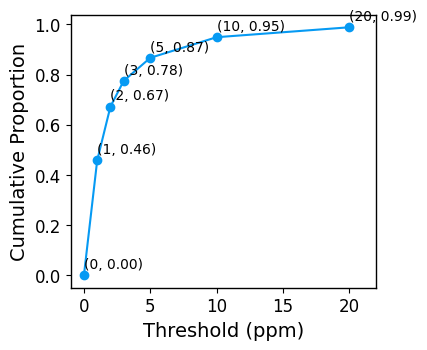

R2 = 0.98
RMSE = 4.64
MAE = 2.569514180563875


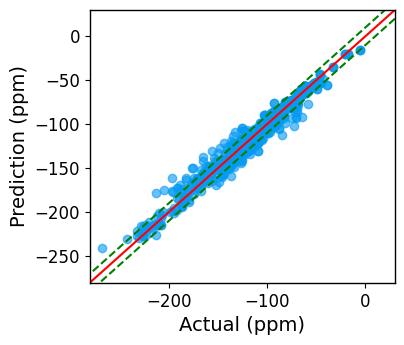

In [48]:
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table, figure_title=None)

## 3.5 Compare Model Performance Using the Validation Dataset <a class="anchor" id="3.5"></a>

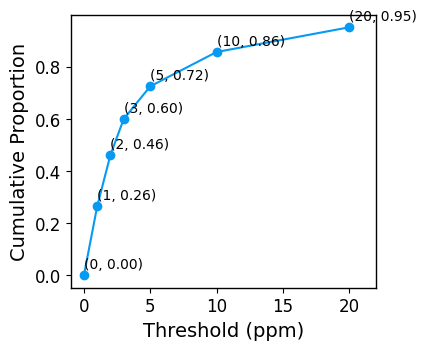

R2 = 0.89
RMSE = 9.53
MAE = 5.19490740481502


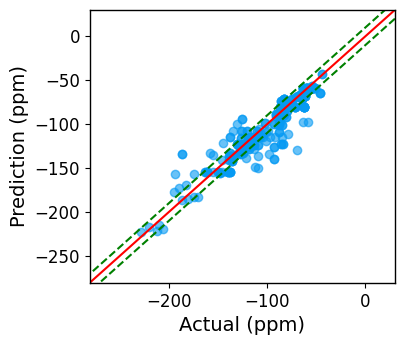

,actual,prediction,diff
4_From_Review_316,-66.00,-67.556465,1.556465
5_From_Review_316,-66.00,-67.556465,1.556465
6_From_Review_316,-66.00,-67.556465,1.556465
7_SO3H_25,-115.13,-115.712044,0.582044
8_SO3H_25,-115.13,-115.712044,0.582044
...,...,...,...
0_Cl_4,-79.65,-79.008560,0.641440
2_Cl_4,-79.65,-79.008560,0.641440
3_Cl_4,-79.65,-79.008560,0.641440
5_Cl_4,-120.25,-121.887535,1.637535


In [49]:
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere2.json"
)
get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path,
    dataset=vali_fluorinated_compounds,
    num_spheres=2,
)

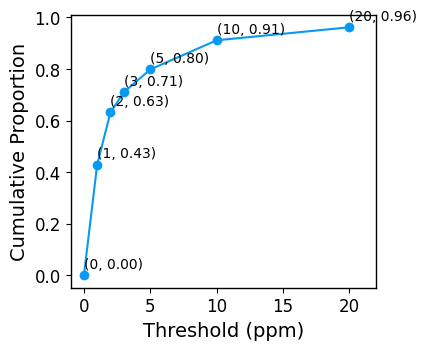

R2 = 0.93
RMSE = 7.79
MAE = 3.784782842233641


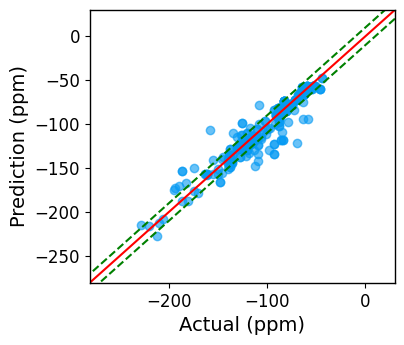

In [50]:
# Test model performance on the validation dataset, 2D atomic features with 3 neighbor atoms
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere3.json"
)
results_table_sphere3 = get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path, vali_fluorinated_compounds, 3
)

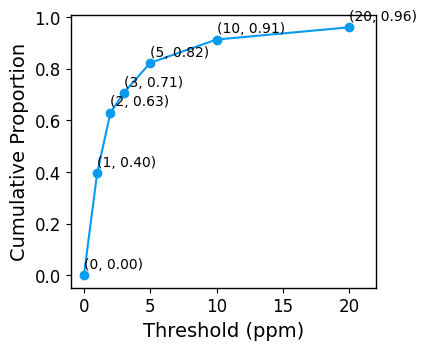

R2 = 0.93
RMSE = 7.70
MAE = 3.767535943314206


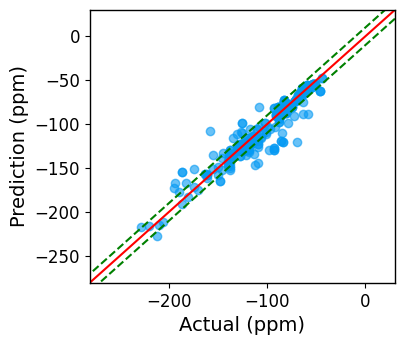

In [51]:
# Test model performance on the validation dataset, 2D atomic features with 4 neighbor atoms
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
)
results_table_sphere4 = get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path, vali_fluorinated_compounds, 4
)

In [52]:
# Saving best results to a CSV file
file_path = os.path.join(
    "..", "artifacts", "results", "XGBoost_2DFeatureSet_validation_dataset_sphere4.csv"
)
results_table_sphere4.to_csv(file_path, encoding="UTF-8")

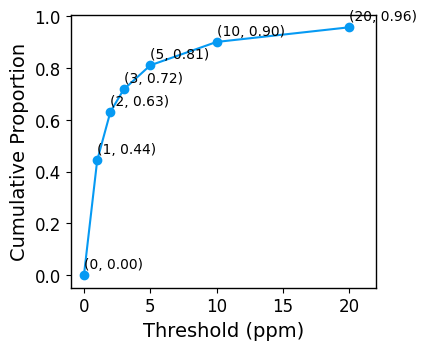

R2 = 0.93
RMSE = 7.91
MAE = 3.826641190321803


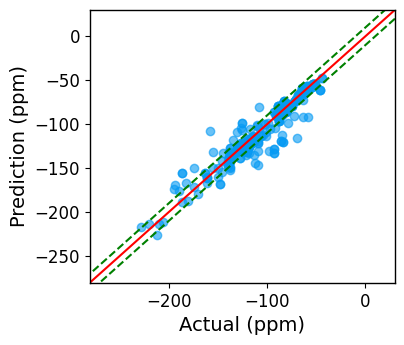

In [53]:
# Test model performance on the validation dataset, 2D atomic features with 5 neighbor atoms
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere5.json"
)
results_table_sphere5 = get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path, vali_fluorinated_compounds, 5
)

Results:
The best performing model used features of atoms from the nearest **three spheres** in 2D space.

## 3.6 Feature Importance Analysis <a class="anchor" id="3.6"></a>
**Top 10 Important Features Evaluated Based on Information Gain**

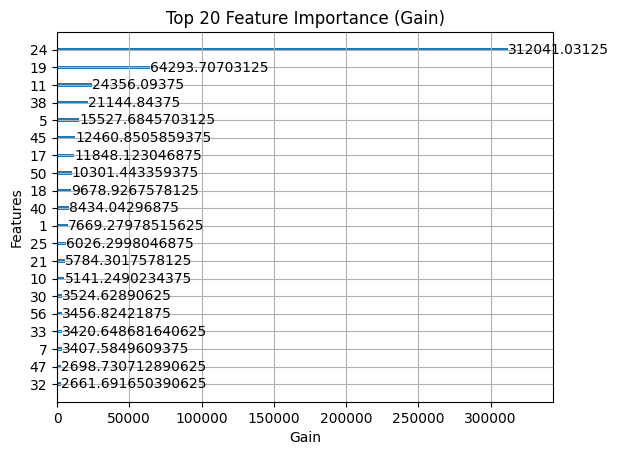

In [54]:
best_model = XGBRegressor()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
)
best_model.load_model(file_path)

xgb.plot_importance(best_model, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importance (Gain)")
plt.xlabel("Gain")
plt.ylabel("Features")
plt.show()

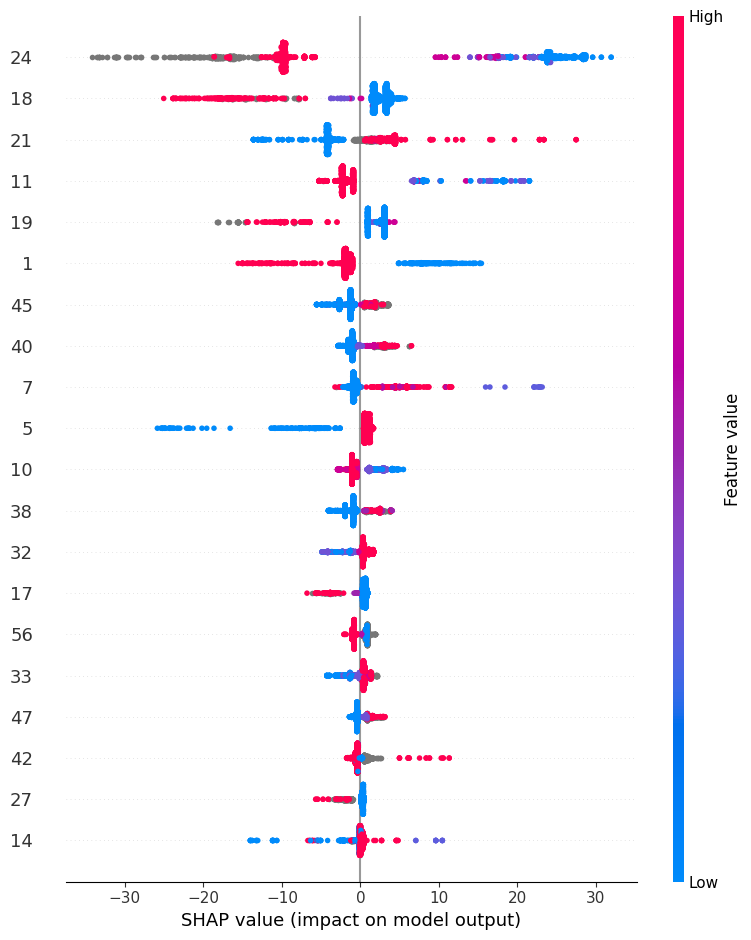

In [55]:
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
train_content = get_2d_descriptors.getDescriptorsFromDataset(
    train_fluorinated_compounds, 4
)

train_content = train_content.dropna(subset=["NMR_Peaks"])
y_train = train_content["NMR_Peaks"]
X_train = train_content.drop(["NMR_Peaks"], axis=1)

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

# Plot the summary plot
shap.summary_plot(shap_values, X_train)

In [56]:
X_content_PFOA = train_content[train_content.index.str.contains("COOH_6")]
X_content_PFOA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,NMR_Peaks
4_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.16
5_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.16
7_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.84
8_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.84
10_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-126.27
20_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-126.27
22_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,

In [57]:
shap_values_with_index_col = pd.DataFrame(shap_values)
shap_values_with_index_col.columns = X_train.columns
shap_values_with_index_col.index = X_train.index

# PFOA = 'COOH_6'
shap_values_PFOA = shap_values_with_index_col[
    shap_values_with_index_col.index.str.contains("COOH_6")
]
shap_values_PFOA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
4_COOH_6,0.0,-1.855622,-0.012391,0.009075,0.0,1.012384,0.175828,-0.926199,0.111755,0.005782,-1.049012,-2.258172,0.001432,0.024623,0.007537,0.038717,0.071491,0.771499,3.855027,3.062154,0.0,-4.311715,-0.002867,0.0,-9.733726,-0.086020,0.021488,0.419330,-0.332054,0.043198,-0.082806,-0.009071,-1.069864,-0.084258,-0.057543,-0.025410,0.337990,-0.028165,-0.781078,0.0,-0.866425,0.0,-0.523050,0.0,0.0,-1.097373,0.0,-0.344196,0.0,-0.102611,...,0.108083,-0.107759,-0.013320,-0.154643,-0.050811,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.005332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5_COOH_6,0.0,-1.855622,-0.012391,0.009075,0.0,1.012384,0.175828,-0.926199,0.111755,0.005782,-1.049012,-2.258172,0.001432,0.024623,0.007537,0.038717,0.071491,0.771499,3.855027,3.062154,0.0,-4.311715,-0.002867,0.0,-9.733726,-0.086020,0.021488,0.419330,-0.332054,0.043198,-0.082806,-0.009071,-1.069864,-0.084258,-0.057543,-0.025410,0.337990,-0.028165,-0.781078,0.0,-0.866425,0.0,-0.523050,0.0,0.0,-1.097373,0.0,-0.344196,0.0,-0.102611,...,0.108083,-0.107759,-0.013320,-0.154643,-0.050811,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.005332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_COOH_6,0.0,-2.014442,-0.012166,0.008310,0.0,0.997417,0.181083,-0.861392,-0.037016,0.005671,-1.075089,-2.282011,0.008571,0.003539,-0.080879,0.029064,-0.027986,0.645578,3.158922,3.022663,0.0,-4.139939,-0.002867,0.0,-10.093122,-0.083538,0.021488,0.304507,0.067513,-0.037339,-0.123990,0.002257,0.287831,0.269792,-0.013422,-0.140506,-0.137078,-0.075397,-0.914427,0.0,-1.021922,0.0,-0.384297,0.0,0.0,-1.227710,0.0,-0.443531,0.0,-0.348713,...,0.118497,0.301120,0.047525,0.131547,0.274452,0.0,-0.009936,0.0,0.0,0.0,0.0,0.373018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8_COOH_6,0.0,-2.014442,-0.012166,0.008310,0.0,0.997417,0.181083,-0.861392,-0.037016,0.005671,-1.075089,-2.282011,0.008571,0.003539,-0.080879,0.029064,-0.027986,0.645578,3.158922,3.022663,0.0,-4.139939,-0.002867,0.0,-10.093122,-0.083538,0.021488,0.304507,0.067513,-0.037339,-0.123990,0.002257,0.287831,0.269792,-0.013422,-0.140506,-0.137078,-0.075397,-0.914427,0.0,-1.021922,0.0,-0.384297,0.0,0.0,-1.227710,0.0,-0.443531,0.0,-0.348713,...,0.118497,0.301120,0.047525,0.131547,0.274452,0.0,-0.009936,0.0,0.0,0.0,0.0,0.373018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10_COOH_6,0.0,-1.896762,-0.012166,0.008311,0.0,1.085301,0.179901,-0.872547,-0.037016,0.009860,-1.076806,-2.266810,0.008571,0.003539,-0.094468,0.029064,-0.029163,0.645578,3.339702,3.069830,0.0,-4.230144,-0.002867,0.0,-9.866159,-0.093250,0.021488,0.338551,0.067164,-0.077269,-0.123990,0.006014,0.318033,0.370259,-0.013422,-0.140280,-0.137078,-0.092756,-0.911546,0.0,-1.039978,0.0,-0.385104,0.0,0.0,-1.270809,0.0,-0.443531,0.0,-0.097812,...,0.118497,0.286841,0.047525,0.131547,0.232478,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.031880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [58]:
pd.set_option("display.max_rows", 100)
# pd.set_option("display.max_columns", 100)
shap_values_PFOA.abs().mean().sort_values(ascending=False)[:20]

24    12.669160
21     4.270940
18     3.109983
19     2.645725
11     1.997562
1      1.752242
45     1.523342
40     1.110862
38     1.102312
10     0.960409
5      0.951850
56     0.843312
7      0.808481
17     0.593448
50     0.586842
42     0.452975
32     0.433835
47     0.429048
33     0.362250
27     0.319660
dtype: float32

## 4.3 Evaluate the Performance of the Models Using the Test Dataset<a class="anchor" id="4.3"></a>

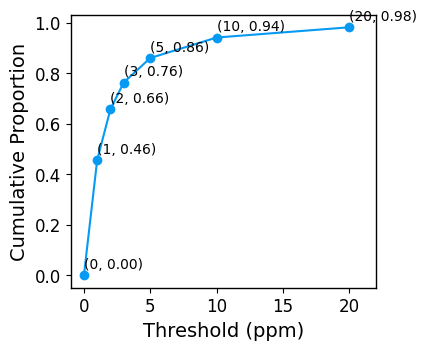

R2 = 0.97
RMSE = 5.09
MAE = 2.6956644540615184


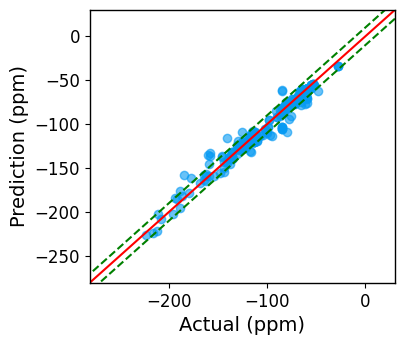

In [59]:
# Comparision of best performing models using the test dataset
# xgboost, 3D atomic features with 5 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")

results_table_test_neighbor_5 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor5.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor5_xgboost.pkl"
        ),
        neighbor_num=5,
        test_dataset=test_fluorinated_compounds,
    )
)

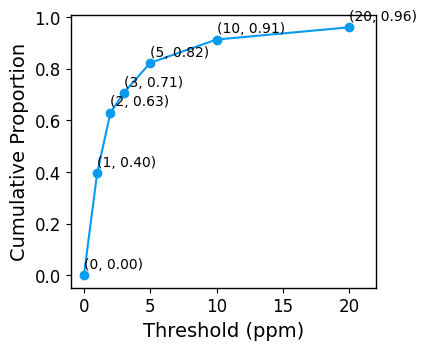

R2 = 0.93
RMSE = 7.70
MAE = 3.767535943314206


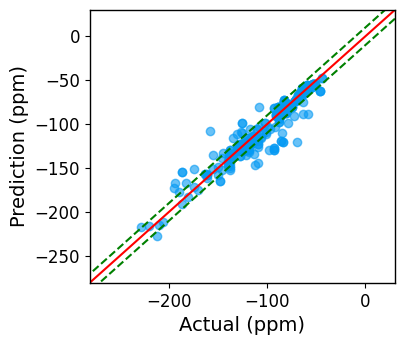

In [60]:
# Test model performance on the test dataset, 2D atomic features with 4 spheres
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
)
results_table_sphere3 = get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path, vali_fluorinated_compounds, 4
)

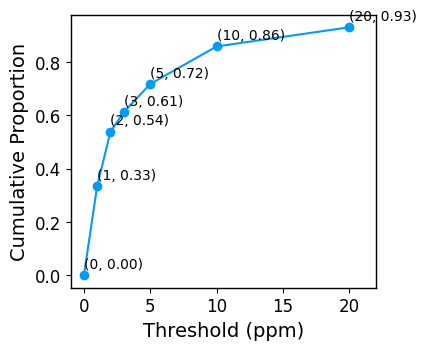

R2 = 0.91
RMSE = 8.69
MAE = 4.843271284018595


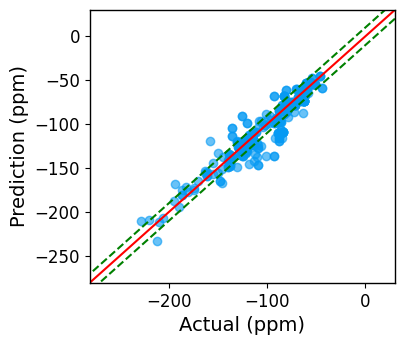

In [61]:
# Ridge model with 2D feature set, spheres = 4

base_file_path = os.path.join("..", "artifacts", "models")
restuls_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=4,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere4.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere4_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere4_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere4_Ridge.pkl"),
)

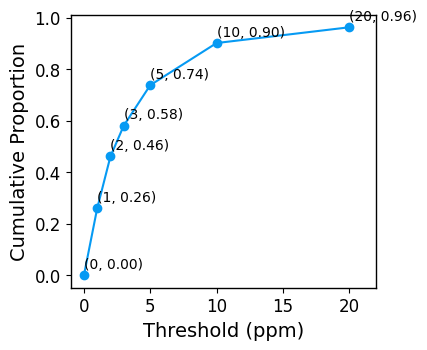

R2 = 0.90
RMSE = 9.04
MAE = 4.545745173748309


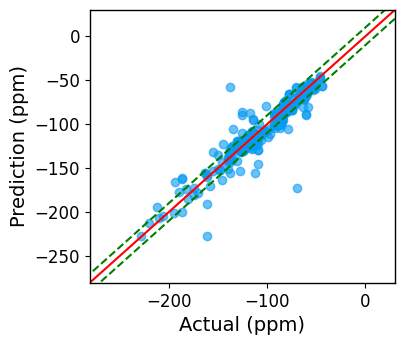

,actual,prediction,diff
4_From_Review_316,-66.00,-67.786912,1.786912
5_From_Review_316,-66.00,-69.123173,3.123173
6_From_Review_316,-66.00,-67.552918,1.552918
7_SO3H_25,-115.13,-108.594309,6.535691
8_SO3H_25,-115.13,-110.457618,4.672382
...,...,...,...
0_Cl_4,-79.65,-79.850552,0.200552
2_Cl_4,-79.65,-82.889173,3.239173
3_Cl_4,-79.65,-82.844766,3.194766
5_Cl_4,-120.25,-122.775369,2.525369


In [62]:
# Ridge model with 3D feature set, neighboring atoms = 5
base_file_path = os.path.join("..", "artifacts", "models")
common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    neighbor_num=5,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor5.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbors5_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor5_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor5_RidgeCV.pkl"),
)

The XGBoost model with 3D feature set with 5 neighboring atoms performes best. 